In [12]:
%matplotlib inline
import os
from plantcv import plantcv as pcv
import cv2
import numpy as np
import matplotlib
matplotlib.rcParams["figure.figsize"] = [7, 7]

In [13]:
# The options class mimics the options function in a PlantCV workflow (mimics using argparse)
class options:
    def __init__(self):
        # Input image
        self.image = "/Users/nfahlgren/Downloads/2017-01-18_1510_ch129-pos01.jpg"
        # Debug = "plot" (Jupyter), "print" (file), or None
        self.debug = "plot"
        # Should we output analysis images from analyze_* functions
        self.writeimg = False
        # Name of results file
        self.result = "2017-01-18_1510_ch129-pos01.txt"

In [14]:
# Initialize instance of options called args to mimic the use of argparse in work flow script
args = options()
pcv.params.debug = args.debug

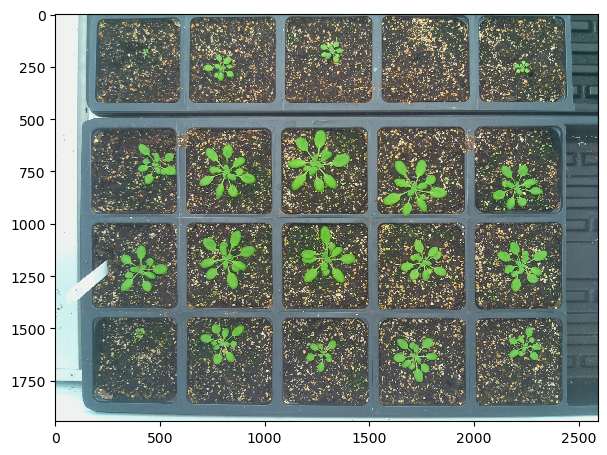

In [15]:
# Open image
img, imgpath, imgname = pcv.readimage(filename=args.image)

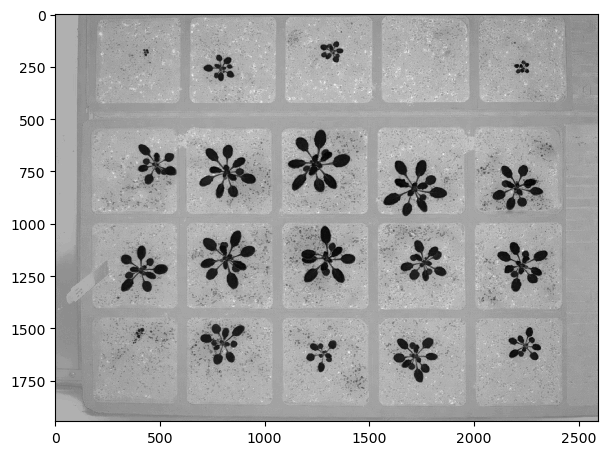

In [16]:
# Convert RGB to LAB and keep the A (green-magenta) channel
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')

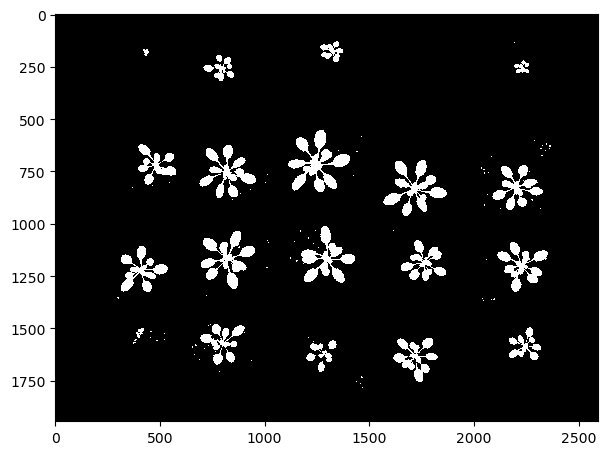

In [17]:
# Threshold the A channel using the Otsu auto-threshold method
bin_img = pcv.threshold.otsu(gray_img=a, max_value=255, object_type="dark")

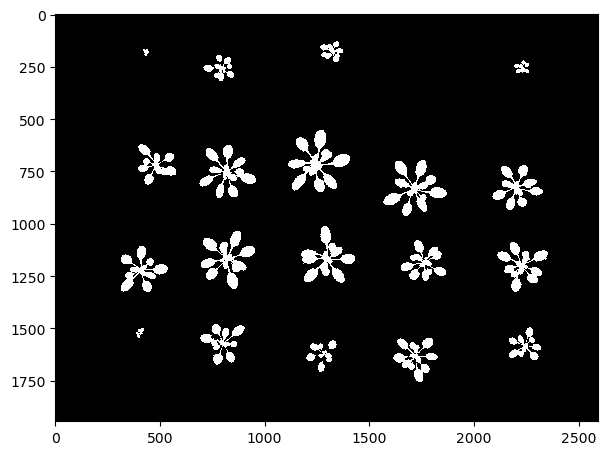

In [18]:
# Remove salt-and-pepper noise from background
cleaned_img = pcv.fill(bin_img=bin_img, size=100)

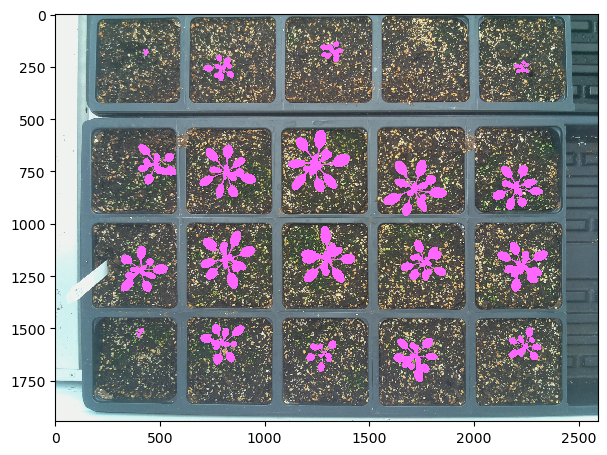

In [23]:
# Detect contours in binary image
c, h = pcv.find_objects(img=img, mask=cleaned_img)

In [24]:
# Cluster contours to detect individual plants
# clusters, contours, contour_hierarchy = pcv.cluster_contours(img=img, roi_objects=all_contours,
#                                                              roi_obj_hierarchy=all_hierarchy, nrow=4, ncol=5)

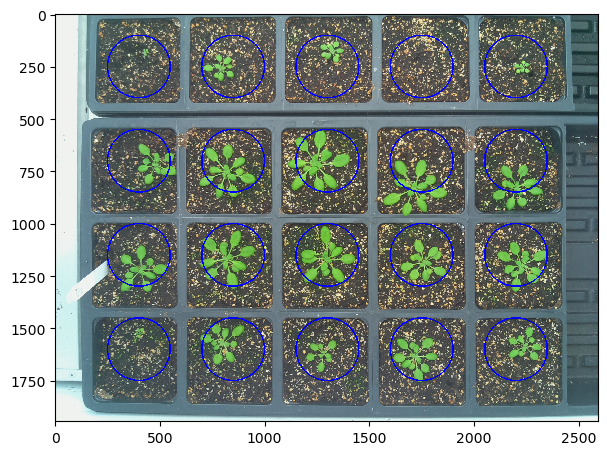

In [25]:
rc, rh = pcv.roi.multi(img=img, coord=(400, 250), nrows=4, ncols=5, radius=150, spacing=(450, 450))

In [36]:
# The result file should exist if plantcv-workflow.py was run
if os.path.exists(args.result):
    # Open the result file
    results = open(args.result, "r")
    # The result file would have image metadata in it from plantcv-workflow.py, read it into memory
    metadata = results.read()
    # Close the file
    results.close()
    # Delete the file, we will create new ones
    os.remove(args.result)
else:
    # If the file did not exist (for testing), initialize metadata as an empty string
    metadata = "{}"

In [39]:
# Turn off debug temporarily, otherwise there will be a lot of plots
pcv.params.debug = None
# Loop over each region of interest
for i, rc_i in enumerate(rc):
    rh_i = rh[i]
    # Find objects associated with the current ROI
    roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=rc_i,
                                                                            roi_hierarchy=rh_i,
                                                                            object_contour=c,
                                                                            obj_hierarchy=h,
                                                                            roi_type='partial')
    # Only proceed if a plant was detected
    if obj_area > 0:
        # Combine objects within the current ROI
        object, mask = pcv.object_composition(img, roi_objects, roi_obj_hierarchy)
        # Analyze the shape of the current plant
        shape_img = pcv.analyze_object(img, object, mask)
        # Add custom output
        pcv.outputs.add_observation(
                variable='roi',
                trait='roi',
                method='roi',
                scale='int',
                datatype=int,
                value=i,
                label='#')
        # At this point we have observations for one plant
        # We can write these out to a unique results file
        # Here I will name the results file with the ROI ID combined with the original result filename
        filename = str(i) + "_" + args.result
        # Save the existing metadata to the new file
        with open(filename, "w") as r:
            r.write(metadata)
        pcv.print_results(filename=filename)
        # The results are saved, now clear out the observations so the next loop adds new ones for the next plant
        pcv.outputs.clear()